# Minilink

Demo of usage

In [28]:
!git clone https://github.com/alx87grd/minilink
import sys
sys.path.append('/content/minilink')

fatal: destination path 'minilink' already exists and is not an empty directory.


In [29]:
from framework import System
from sources import Step
from diagram import DiagramSystem
import numpy as np

# Custom sys

Create a system object based two equations

$\dot{x}=f(x,u,t)$

$y=h(x,u,t)$

In [30]:
class Integrator(System):

    def __init__(self):

        n = 1 # Dimension of x
        m = 1 # Dimension of u
        p = 1 # Dimension of y

        super().__init__(n, m, p)
        self.name = "Integrator"

    def f(self, x, u, t=0, params=None):

        dx = u

        return dx

    def h(self, x, u, t=0, params=None):

        y = x

        return y

A controller is also a system but with no states, thus only an output equation

In [31]:
class PropController(System):
    def __init__(self):
        super().__init__(0, 2, 1)

        self.params = {
            "Kp": 10.0,
        }

        self.name = "Controller"

        self.inputs = {}
        self.add_input_port(1, "ref", nominal_value=np.array([0.0]))
        self.add_input_port(1, "y", nominal_value=np.array([0.0]))

        self.outputs = {}
        self.add_output_port(1, "u", function=self.ctl, dependencies=["ref", "y"])

    ######################################################################
    def ctl(self, x, u, t=0, params=None):

        if params is None:
            params = self.params

        Kp = params["Kp"]

        r = u[0]
        y = u[1]

        u = Kp * (r - y)

        return np.array([u])

# Diagram building

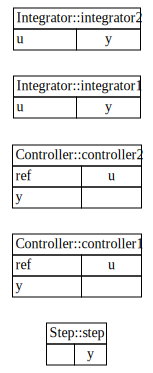

In [32]:
## Cascade controller diagram

# Plant system
sys1 = Integrator()
sys1.state.labels = ["v"]
sys1.x0[0] = 10.0
sys2 = Integrator()
sys2.state.labels = ["x"]
sys2.x0[0] = 10.0

# Controllers
ctl1 = PropController()
ctl1.params["Kp"] = 2.0
ctl2 = PropController()
ctl2.params["Kp"] = 5.0

# Source input
step = Step()
step.params["initial_value"] = np.array([0.0])
step.params["final_value"] = np.array([5.0])
step.params["step_time"] = 5.0

# # Diagram
diagram = DiagramSystem()

diagram.add_subsystem(step, "step")
diagram.add_subsystem(ctl1, "controller1")
diagram.add_subsystem(ctl2, "controller2")
diagram.add_subsystem(sys1, "integrator1")
diagram.add_subsystem(sys2, "integrator2")

diagram

Connected integrator1:y to integrator2:u
Connected controller2:u to integrator1:u
Connected integrator1:y to controller2:y
Connected controller1:u to controller2:ref
Connected integrator2:y to controller1:y
Connected step:y to controller1:ref


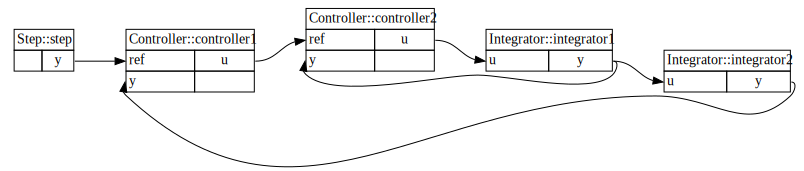

In [33]:
diagram.connect("integrator1", "y", "integrator2", "u")
diagram.connect("controller2", "u", "integrator1", "u")
diagram.connect("integrator1", "y", "controller2", "y")
diagram.connect("controller1", "u", "controller2", "ref")
diagram.connect("integrator2", "y", "controller1", "y")
diagram.connect("step", "y", "controller1", "ref")
diagram

Simulator:
--------------
Simulating system Diagram from t=0 to t=10
Automatic dt based on the smallest time constant of the system
Time steps = 100001, dt=0.0001 and solver= scipy


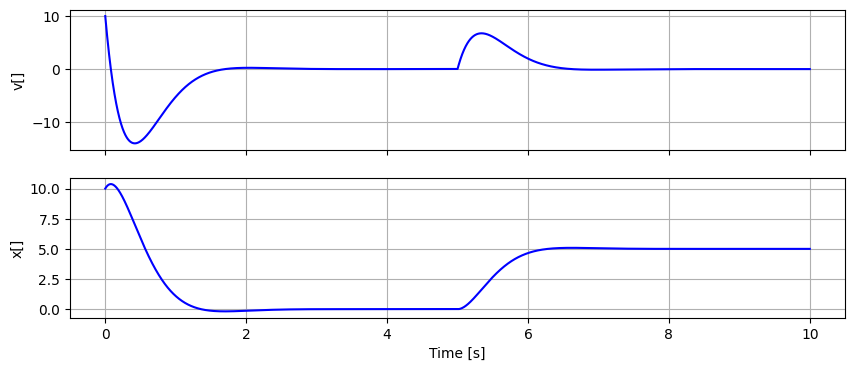

In [34]:
diagram.compute_trajectory()

# Noise ports exemple

In [35]:
from minilink_tests import Pendulum, PDController
from sources import WhiteNoise

Connected step:y to controller:ref
Connected controller:u to plant:u
Connected plant:y to controller:y
Connected noise:y to plant:w
Connected noise2:y to plant:v


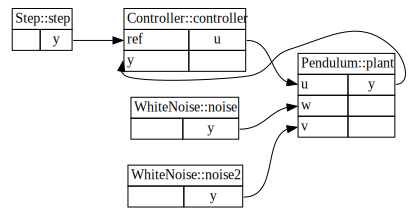

In [36]:
# Plant system
sys = Pendulum()

sys.params["m"] = 1.0
sys.params["l"] = 5.0

sys.x0[0] = 2.0

# Source input
step = Step()
step.params["initial_value"] = np.array([0.0])
step.params["final_value"] = np.array([1.0])
step.params["step_time"] = 10.0

# Noisy input
noise = WhiteNoise(1)
noise.params["var"] = 1.0
noise.params["mean"] = 0.0
noise.params["seed"] = 1

# Noisy measurement
noise2 = WhiteNoise(1)
noise2.params["var"] = 0.1
noise2.params["mean"] = 0.0
noise2.params["seed"] = 2

# Closed loop system
ctl = PDController()
ctl.params["Kp"] = 1000.0
ctl.params["Kd"] = 100.0

# Diagram
diagram2 = DiagramSystem()

diagram2.add_subsystem(step, "step")
diagram2.add_subsystem(ctl, "controller")
diagram2.add_subsystem(sys, "plant")
diagram2.add_subsystem(noise, "noise")
diagram2.add_subsystem(noise2, "noise2")

diagram2.connect("step", "y", "controller", "ref")
diagram2.connect("controller", "u", "plant", "u")
diagram2.connect("plant", "y", "controller", "y")
diagram2.connect("noise", "y", "plant", "w")
diagram2.connect("noise2", "y", "plant", "v")
diagram2

Simulator:
--------------
Simulating system Diagram from t=0 to t=10
Time steps = 1001, dt=0.01 and solver= euler


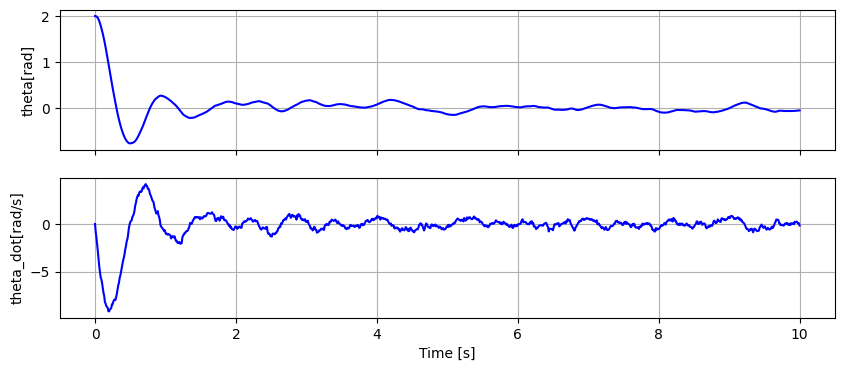

In [37]:
diagram2.compute_trajectory( solver = 'euler', dt = 0.01 ) # White noise is not a continuous system.. and scipy does not like it..

Simulator:
--------------
Simulating system Diagram from t=0 to t=10
Time steps = 1001, dt=0.01 and solver= euler


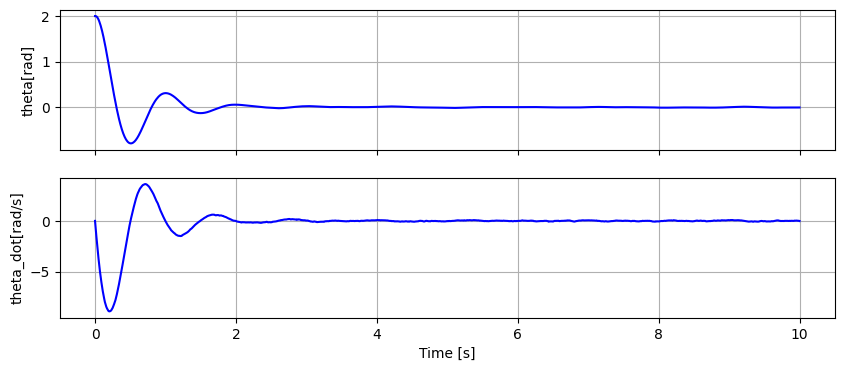

In [38]:
diagram2.subsystems['noise'].params['var'] = 0.001
diagram2.subsystems['noise2'].params['var'] = 0.001
diagram2.compute_trajectory( solver = 'euler', dt = 0.01 )

Simulator:
--------------
Simulating system Diagram from t=0 to t=10
Time steps = 1001, dt=0.01 and solver= euler


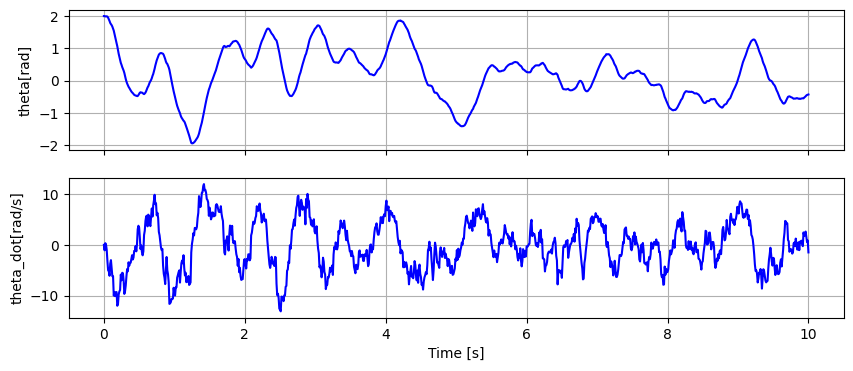

In [39]:
diagram2.subsystems['noise'].params['var'] = 10.0
diagram2.subsystems['noise2'].params['var'] = 10.0
diagram2.compute_trajectory( solver = 'euler', dt = 0.01 )